# Animal Influenza Emergence Risk Predictions
- **Note: Enet and Qnet are interchangeable, Qnet was the old name**
- Uses the Emergenet package to generate emergence risk scores for animal strains
- Collected animal HA and NA strains from January 1, 2020 - September 30, 2022
- Used Enets from `enet_models/current_enets/`

In [54]:
import os 
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import math
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO

# linear model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from emergenet import Enet, save_model, load_model
from quasinet.qnet import Qnet, qdistance, qdistance_matrix, membership_degree, save_qnet, load_qnet
from zedstat.textable import textable

In [3]:
DATA_DIR = 'raw_data/gisaid_animal/'
HUMAN_DATA_DIR = 'raw_data/gisaid_current/'
ENET_DIR = 'enet_models/current_enets/'
OUT_DIR = 'results/animal_predictions/'

NA_TRUNC = 449
HA_TRUNC = 550

FILES = ['h1n1', 'h1n2', 'h3n2', 'h5n1', 'h5n2', 'h5n6', 'h5n8', 'h7', 'h9n2']

In [56]:
# input: na risk, ha risk, geometric mean
# output: emergence and impact predictions
def predict_irat(emergence_mod, impact_mod, ha_risk, na_risk, geom_mean):
    df = pd.DataFrame({'Geometric_Mean':[geom_mean],
                       'HA_Avg_Qdist':[ha_risk],
                       'NA_Avg_Qdist':[na_risk]})
    emergence_risk = emergence_mod.predict(df)[0]
    impact_risk = impact_mod.predict(df)[0]
    if geom_mean > 0.3:
        emergence_risk = 3.8
        impact_risk = 4.45
    return emergence_risk, impact_risk


# input: fasta file name, length to truncate each sequence
# output: dataframe of sequences (containing only name and accession)
def parse_fasta(file_name, trunc):
    name = []
    acc = []
    subtype = []
    for record in SeqIO.parse(file_name, 'fasta'):
        if len(record.seq) < trunc:
            continue
        name.append(record.id.split('|')[0])
        acc.append(record.id.split('|')[4])
        subtype.append(record.id.split('|')[1][-4:])
    df = pd.DataFrame({'id':name, 'subtype':subtype, 'accession':acc})
    return df

## Predictions
- For each animal strain, compute average NA and HA risk compared to human population of that strain
    - Do it 10 times for variance computation
    - For variance computation, compute 10 impact/emergence scores for each strain and take sample variance
    
### Running Processes

Computations are done in:
- `animal_predictions.py`
- `run_animal_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_animal_predictions.sh
./run_animal_predictions.sh`

## Scale Predictions with GLM

In [57]:
data = pd.read_csv('results/irat_average_qdistances.csv')
data = data.rename(columns={'Potential Emergence Estimate':'IRAT_Emergence_Score',
                            'Potential Impact Estimate':'IRAT_Impact_Score',
                            'Avg. Geometric Mean':'Geometric_Mean',
                            'Avg. HA Qdistance':'HA_Avg_Qdist',
                            'Avg. NA Qdistance':'NA_Avg_Qdist'})
# remove Yunnan and Netherlands outliers, and Duck strain
data = data[(data['HA_Avg_Qdist'] > 0) & (data['NA_Avg_Qdist'] > 0)].drop(labels=[10, 12], axis=0)

# complex emergence model
formula1 = 'IRAT_Emergence_Score ~ Geometric_Mean + HA_Avg_Qdist:NA_Avg_Qdist'
mod1 = smf.glm(formula=formula1, data=data).fit()
print(mod1.summary())

# complex impact model
formula2 = 'IRAT_Impact_Score ~ Geometric_Mean + HA_Avg_Qdist:NA_Avg_Qdist'
mod2 = smf.glm(formula=formula2, data=data).fit()
print(mod2.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     IRAT_Emergence_Score   No. Observations:                   20
Model:                              GLM   Df Residuals:                       17
Model Family:                  Gaussian   Df Model:                            2
Link Function:                 identity   Scale:                         0.70699
Method:                            IRLS   Log-Likelihood:                -23.286
Date:                  Tue, 14 Mar 2023   Deviance:                       12.019
Time:                          18:51:44   Pearson chi2:                     12.0
No. Iterations:                       3   Pseudo R-squ. (CS):             0.7956
Covariance Type:              nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
In

In [58]:
df_merged = pd.DataFrame({})

for FILE in tqdm(FILES):
    ha_df = parse_fasta(DATA_DIR + FILE + '_ha.fasta', HA_TRUNC)
    na_df = parse_fasta(DATA_DIR + FILE + '_na.fasta', NA_TRUNC)
    
    # df1: metadata
    df1 = ha_df.merge(na_df, how='inner', on='id').drop(columns=['subtype_y'])
    df1.rename(columns={'subtype_x':'subtype','accession_x':'ha_accession', 'accession_y':'na_accession'}, inplace=True)
    
    # df2: results
    df2 = pd.read_csv(OUT_DIR + FILE + '.csv')
    df2['ha_risk'] = df2['ha_risk'].apply(eval)
    df2['na_risk'] = df2['na_risk'].apply(eval)
    df2['geometric_mean_risk'] = df2['geometric_mean_risk'].apply(eval)
    emergence_risks = []
    emergence_risks_var = []
    impact_risks = []
    impact_risks_var = []
    for i in range(len(df2)):
        ha = df2['ha_risk'].iloc[i]
        na = df2['na_risk'].iloc[i]
        gm = df2['geometric_mean_risk'].iloc[i]
        emergence_risk = []
        impact_risk = []
        for j in range(10):
            er, ir = predict_irat(mod1, mod2, ha[j], na[j], gm[j])
            emergence_risk.append(er)
            impact_risk.append(ir)
        emergence_risks.append(np.mean(emergence_risk))
        emergence_risks_var.append(np.var(emergence_risk))
        impact_risks.append(np.mean(impact_risk))
        impact_risks_var.append(np.var(impact_risk))
    df2['emergence_risk'] = emergence_risks
    df2['emergence_risk_var'] = emergence_risks_var
    df2['impact_risk'] = impact_risks
    df2['impact_risk_var'] = impact_risks_var
    
    # df3: merge df1 and df2
    df3 = df1.merge(df2, how='inner', on='id').drop_duplicates(subset=['id'])
    df3 = df3[df3['id'] != 'not_release_-_host_x_isolate_name_not_match']
    if len(df_merged) == 0:
        df_merged = df3
    else:
        df_merged = df_merged.append(df3, ignore_index=True)

df_merged.to_csv(OUT_DIR + 'combined_results.csv', index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

## Results

In [4]:
df_merged = pd.read_csv(OUT_DIR + 'combined_results.csv')
df_merged.sort_values(by='emergence_risk', ascending=False).head(75)

,id,subtype,ha_accession,na_accession,ha,na,ha_risk,na_risk,geometric_mean_risk,emergence_risk,emergence_risk_var,impact_risk,impact_risk_var
218,A/swine/Missouri/A02524711/2020,H1N1,EPI1818121,EPI1818122,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007702821053332326, 0.00794167832708008, 0....","[0.0016000691389129699, 0.0019043683598783635,...","[0.0035107045233124007, 0.003888943420830784, ...",6.782248,0.000006,6.767254,0.000005
142,A/swine/Wisconsin/A02479131/2020,H1N1,EPI1780098,EPI1780099,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007716075008593186, 0.007954902925217054, 0...","[0.0016000691389129699, 0.0019043683598783635,...","[0.0035137235939651807, 0.0038921800365203044,...",6.782179,0.000006,6.767194,0.000005
157,A/swine/Missouri/A02479157/2020,H1N1,EPI1780243,EPI1780244,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007726353641666193, 0.007963408153388233, 0...","[0.0016000691389129699, 0.0019043683598783635,...","[0.003516063141975399, 0.0038942602024145657, ...",6.782131,0.000006,6.767151,0.000005
124,A/swine/Missouri/A02479058/2020,H1N1,EPI1778732,EPI1778733,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007702821053332326, 0.00794167832708008, 0....","[0.0016092572145346776, 0.0019136101393346001,...","[0.0035207698522261646, 0.003898368398450086, ...",6.782034,0.000006,6.767065,0.000005
165,A/swine/North_Carolina/A02479181/2020,H1N1,EPI1780419,EPI1780420,MKAILVVMLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGTANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.007702821053332326, 0.00794167832708008, 0....","[0.0016092572145346776, 0.0019136101393346001,...","[0.0035207698522261646, 0.003898368398450086, ...",6.782034,0.000006,6.767065,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,A/swine/Indiana/A02479362/2020,H3N2,EPI1769192,EPI1769194,MKTIIALSYILCLVFAQKIPGNDNGTATLCLGHHAVPNGTIVKTIT...,MNPNQRIITIGSVSLTISTICFFMQIAILITTVTLHFKQYEFKPPP...,"[0.009721176074197873, 0.005822187428950779, 0...","[0.006678902429420306, 0.0066599839081430455, ...","[0.008057715960418481, 0.006227011689968545, 0...",6.712847,0.000531,6.706014,0.000413
36,A/swine/Iowa/A02479344/2020,H1N1,EPI1769150,EPI1769151,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.00821172511841073, 0.007965287273851984, 0....","[0.0060261469759550785, 0.006238197255077215, ...","[0.007034561997003451, 0.007049044843639805, 0...",6.710344,0.000016,6.703803,0.000013
269,A/swine/Nebraska/A01378046/2020,H1N1,EPI1832818,EPI1832820,MKAILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGMANLILQIGNIISIWISHSIQIGNQSRF...,"[0.007112315624504041, 0.007026703777220103, 0...","[0.007414155940579137, 0.00754477139519188, 0....","[0.007261667655483171, 0.007281131344843119, 0...",6.706346,0.000025,6.700277,0.000019
650,A/swine/France/22-200193/2020,H1N1,EPI1975364,EPI1975366,MKAILVVLLYTFTTAKADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,MNPNQKIITIGSICMTIGMANLILQIGNIISIWVSHSIQIGNQSQI...,"[0.008094904300205182, 0.007858465092403755, 0...","[0.006463402620384358, 0.006677237017540268, 0...","[0.0072332997771215575, 0.007243813499535058, ...",6.706145,0.000018,6.700100,0.000014


In [7]:
len(df_merged[df_merged['emergence_risk'] > 6.0])

1756

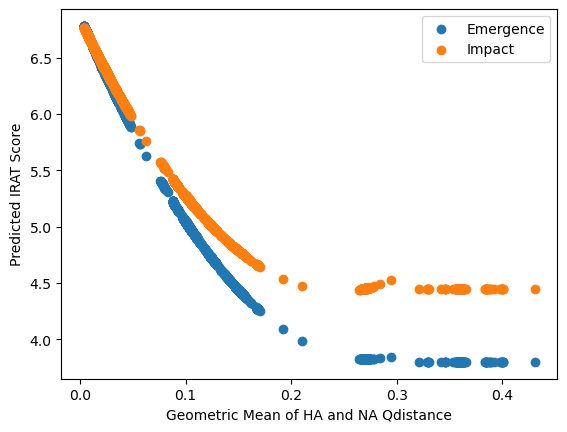

In [60]:
plt.scatter(df_merged['geometric_mean_risk'].apply(eval).apply(np.mean), df_merged['emergence_risk'], label='Emergence')
plt.scatter(df_merged['geometric_mean_risk'].apply(eval).apply(np.mean), df_merged['impact_risk'], label='Impact')
plt.xlabel('Geometric Mean of HA and NA Qdistance')
plt.ylabel('Predicted IRAT Score')
plt.legend();

In [61]:
df_merged.groupby(by='subtype').count()['id']

subtype
H1N1     938
H1N2     784
H3N2     826
H5N1    1598
H5N2      20
H5N6     140
H5N8    1382
H7N1       3
H7N2       1
H7N3      99
H7N5       1
H7N6       8
H7N7      11
H7N8       3
H7N9      17
H9N2     235
Name: id, dtype: int64